In [1]:
import sys

sys.path.append("../../..")

import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
from matplotlib import rc
import mpl_toolkits.axes_grid1.inset_locator as inloc
import scipy.stats as stats
import src.energy_effects_t2k.convolution as conv
import src.nu_osc.osc_prob as osc
import src.nu_osc.default_parameters as param
from numba import jit

In [2]:
rc("figure", figsize=(10, 5))
# rc('lines', linewidth=2)
rc("axes", labelsize=12, linewidth=1, grid=True, labelpad=-1, axisbelow=True)
rc("axes.spines", right=True)
rc("xtick", direction="in", labelsize=12, top=True)
rc("xtick.major", width=0.8, size=5)
rc("ytick", direction="in", labelsize=12, right=True)
rc("ytick.major", width=0.8, size=5)
rc("legend", fancybox=False, fontsize=12, shadow=False)
rc(
    "grid",
    linewidth=1.0,
)  # ls='dotted')
# import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [3]:
colors = {
    "numu": "darkgreen",
    "antinumu": "darkseagreen",
    "nue": "red",
    "antinue": "rosybrown",
    "nutau": "teal",
    "antinutau": "cadetblue",
}

In [4]:
from iminuit import Minuit
from iminuit.cost import LeastSquares

In [5]:
def line(x, α, β):
    return α + x * β


rng = np.random.default_rng(1)
data_x = np.linspace(0, 1, 10)
data_yerr = 0.1
data_y = rng.normal(line(data_x, 1, 2), data_yerr)

In [6]:
least_squares = LeastSquares(data_x, data_y, data_yerr, line)

m = Minuit(least_squares, α=0, β=0)

m.limits = [(0, 2), (0, 3)]

# m.errordef = Minuit.LIKELIHOOD

m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.959 (χ²/ndof = 0.5)      │              Nfcn = 109              │
│ EDM = 1.21e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │   1.02    │   0.06    │            │            │    0    │    2    │       │
│ 1 │ β    │    2.0    │    0.1    │            │            │    0    │    3    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       α       β │
├───┼─────────────────┤
│ α │ 0.00345 -0.0049 │
│ β │ -0.0049 0.00982 │
└───┴─────────────────┘

In [7]:
t2kflux_2020_plus250kA_nominal_sk = conv.fluximport(
    "t2kflux_2020_plus250kA_nominal_sk.csv"
)

ccqe_interp = conv.xsecimport(
    name="neutrino_ccqe.csv",
    mode="true filter interp",
    keep_left=5,
    on=(t2kflux_2020_plus250kA_nominal_sk.minE + t2kflux_2020_plus250kA_nominal_sk.maxE)
    / 2,
)

number = pd.DataFrame()
for key in ["minE", "maxE"]:
    number[key] = t2kflux_2020_plus250kA_nominal_sk[key]
for key in ["numu", "antinumu", "nue", "antinue"]:
    number[key] = (
        (ccqe_interp.xsec * t2kflux_2020_plus250kA_nominal_sk[key] / (50 * 1e21))
        * param.SK_POT["FHC"]
        * param.TOT_NEUTRONS
        * 2
    )
number["nutau"] = 0.0
number["antinutau"] = 0.0


def sk_hist(
    θ23=param.NUFIT["theta_23"]["bf"],
    δCP=param.NUFIT["delta_CP"]["bf"],
    Δ2m32=param.NUFIT["Dm_square_32"]["bf"],
):
    return conv.oscillate(
        to_oscillate=number, theta_23=θ23, delta_cp=δCP, dm2_atm=Δ2m32
    )

In [8]:
sk_hist_bf = sk_hist()

In [9]:
def t2k_likelihood(θ23, δCP, Δ2m32):
    sk_hist_obs = sk_hist(θ23=θ23, δCP=δCP, Δ2m32=Δ2m32)
    sk_hist_exp = sk_hist()
    N_obs = sk_hist_obs["numu"] * (sk_hist_obs.maxE - sk_hist_obs.minE)
    N_exp = sk_hist_exp["numu"] * (sk_hist_exp.maxE - sk_hist_exp.minE)
    l = (N_exp - N_obs + N_obs * np.log(N_obs / N_exp)).sum()
    return l

In [10]:
t2k_likelihood(
    θ23=param.NUFIT["theta_23"]["bf"],
    δCP=param.NUFIT["delta_CP"]["bf"],
    Δ2m32=-param.NUFIT["Dm_square_32"]["bf"],
)

0.0004901871142343673

In [11]:
some_bin = np.linspace(0e-3, 10e-3, 100)

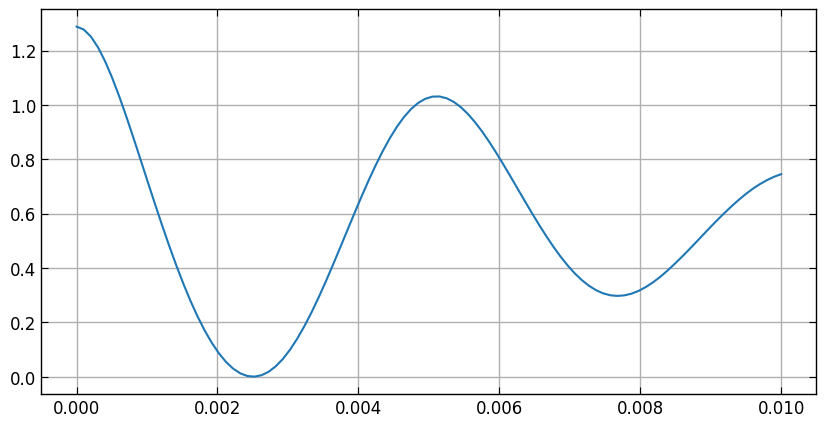

In [12]:
plt.plot(
    some_bin,
    [
        t2k_likelihood(
            θ23=param.NUFIT["theta_23"]["bf"],
            δCP=param.NUFIT["delta_CP"]["bf"],
            Δ2m32=x,
        )
        for x in some_bin
    ],
)
plt.show()

In [13]:
t2k_likelihood.errordef = Minuit.LIKELIHOOD

In [14]:
m = Minuit(
    t2k_likelihood,
    θ23=param.NUFIT["theta_23"]["bf"],
    δCP=param.NUFIT["delta_CP"]["bf"],
    Δ2m32=1e-3,
)

In [15]:
# m.fixed["θ23"] = True
m.fixed["δCP"] = True

In [16]:
m.limits = [(0, 2 * np.pi), (0, 2 * np.pi), (0, 5e-3)]

In [17]:
# m.errors = 1e-6

In [18]:
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,θ23,0.738,0.007,,,0,6.28,
1,δCP,4.05,0.04,,,0,6.28,yes
2,Δ2m32,1.00e-3,0.01e-3,,,0,0.005,


In [19]:
m.migrad()
m.hesse()
m.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.629e-07                  │              Nfcn = 176              │
│ EDM = 2.63e-07 (Goal: 0.0001)    │           time = 211.3 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ θ23   │   0.74    │   0.55    │   -0.35    │    0.48    │    0    │ 6.28319 │       │
│ 1 │ δCP   │   4.05    │   0.04    │            │            │    0    │ 6.28319 │  yes  │
│ 2 │ Δ2m32 │  0.0025   │  0.0011   │  -0.0012   │   0.0013   │    0    │  0.005  │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │          θ23          │         Δ2m32         │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.35   │   0.48    │  -0.0012  │  0.0013   │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌───────┬────────────────────────────┐
│       │      θ23      δCP    Δ2m32 │
├───────┼────────────────────────────┤
│   θ23 │     0.31     0.00 -35.0e-6 │
│   δCP │     0.00        0        0 │
│ Δ2m32 │ -35.0e-6        0 1.34e-06 │
└───────┴────────────────────────────┘

/home/pierre/github/energy-effects-T2K/.venv/lib/python3.11/site-packages/iminuit/minuit.py:2245: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax[i, i].set_xlim(*prange[par1])
/home/pierre/github/energy-effects-T2K/.venv/lib/python3.11/site-packages/iminuit/minuit.py:2251: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax[j, i].set_xlim(*prange[par1])


(<Figure size 1000x500 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='θ23', ylabel='Δ2m32'>, <Axes: xlabel='Δ2m32'>]],
       dtype=object))

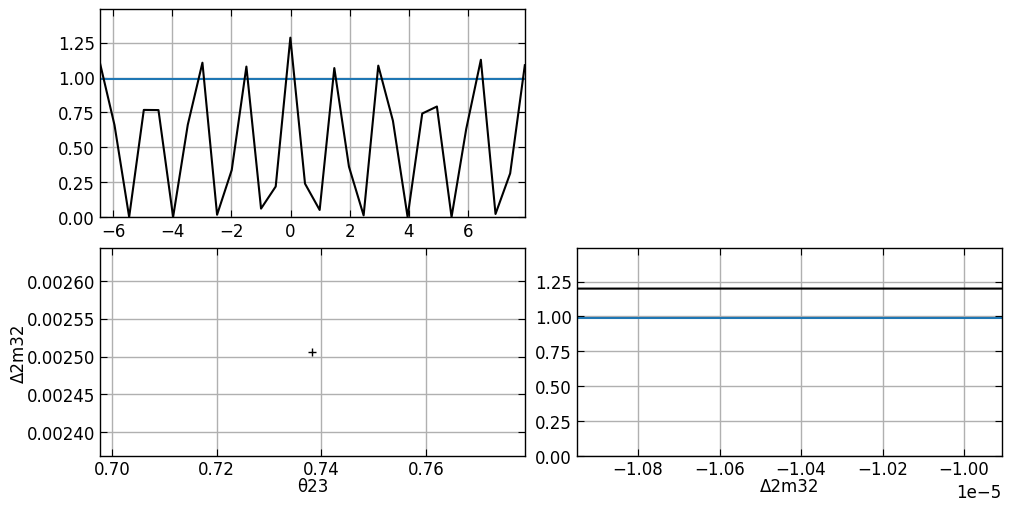

In [20]:
m.draw_mnmatrix()

(array([0.00027273, 0.00042674, 0.00058074, 0.00073475, 0.00088876,
        0.00104277, 0.00119677, 0.00135078, 0.00150479, 0.0016588 ,
        0.0018128 , 0.00196681, 0.00212082, 0.00227483, 0.00242883,
        0.00258284, 0.00273685, 0.00289086, 0.00304486, 0.00319887,
        0.00335288, 0.00350689, 0.0036609 , 0.0038149 , 0.00396891,
        0.00412292, 0.00427693, 0.00443093, 0.00458494, 0.00473895]),
 array([1.22299556e+00, 1.14458145e+00, 1.04432849e+00, 9.29720226e-01,
        8.07602976e-01, 6.83701898e-01, 5.62523336e-01, 4.47616362e-01,
        3.41854232e-01, 2.47635787e-01, 1.67011271e-01, 1.01355824e-01,
        5.12798255e-02, 1.72955785e-02, 0.00000000e+00, 1.01251310e-04,
        1.77392748e-02, 5.23540305e-02, 1.02695482e-01, 1.66977951e-01,
        2.42575662e-01, 3.28262746e-01, 4.20712722e-01, 5.16688760e-01,
        6.12829083e-01, 7.05598021e-01, 7.91605539e-01, 8.68587918e-01,
        9.31806167e-01, 9.79721026e-01]))

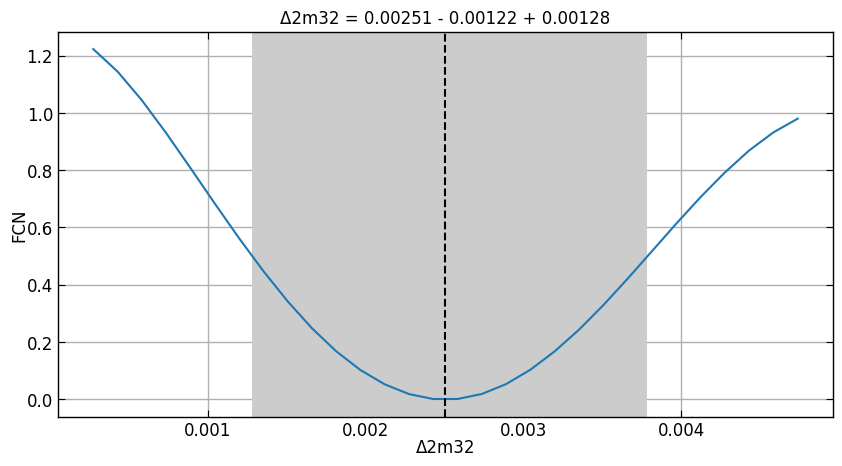

In [21]:
m.draw_mnprofile("Δ2m32")

In [22]:
sk_hist_fit = sk_hist(*m.values)

In [23]:
m.values

<ValueView θ23=0.738269228562493 δCP=4.049163864626845 Δ2m32=0.00250583852804363>

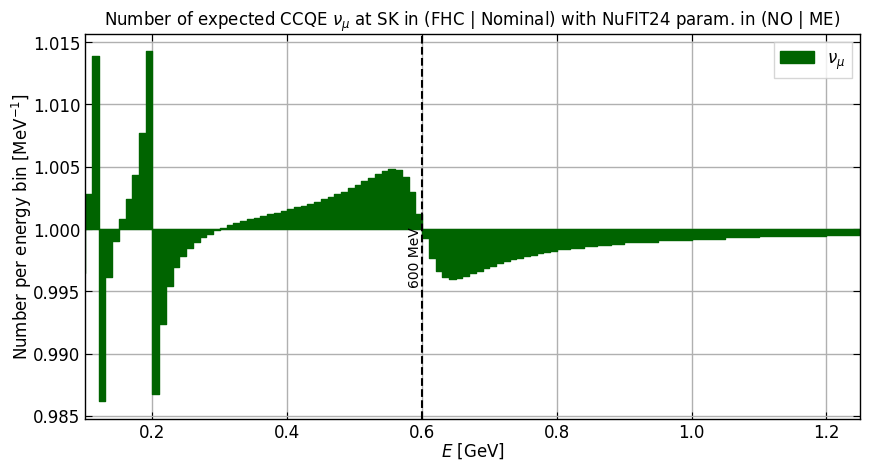

In [24]:
for key in ["numu"]:
    plt.fill_between(
        sk_hist_bf.minE,
        sk_hist_fit[key] / sk_hist_bf[key],
        1,
        label=conv.print_dict[key],
        color=colors[key],
        step="post",
        # alpha=.5,
        # linestyle='--',
    )


plt.axvline(x=0.6, linestyle="--", color="black")
ax = plt.gca()
plt.text(
    x=0.6,
    y=0.5,
    s=r"600 MeV",
    ha="right",
    va="top",
    rotation=90,
    transform=ax.get_xaxis_transform(),
)

# plt.xscale("log")
# plt.yscale("log")
plt.xlabel(r"$E$ [GeV]")
plt.ylabel(r"Number per energy bin [$\text{MeV}^{-1}$]")
# plt.ylim(bottom=1e-1)
plt.xlim([0.1, 1.25])
plt.title(
    r"Number of expected CCQE $\nu_\mu$ at SK in (FHC | Nominal) with NuFIT24 param. in (NO | ME)"
)
plt.legend()

plt.show()